In [65]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

from grokking.dataset import ModularArithmetic, Operator
from grokking.transformer import Transformer
from grokking.utils import generate_run_name
from grokking.learner import Config, GrokkingLearner

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Unifying Grokking & DD

In [2]:
config = Config(
    lr=1e-3,
    d_model=128,
    weight_decay=1.,
    test_acc_criterion=1.,
    device=DEVICE,  
)

In [3]:
# Dataset

train_dataset, val_dataset = ModularArithmetic.generate_split(
    operator=config.operator,
    modulus=config.modulus,
    frac_label_noise=config.frac_label_noise,
    seed=config.seed,
    shuffle=config.shuffle,
    frac_train=config.frac_train,
)

# Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)

In [4]:
# Logging
date_time = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
mode = "disabled" if config.no_logging else None

In [5]:
# Training

def train_test_run():
    learner = GrokkingLearner.create(config, train_dataloader, val_dataloader)

    if config.resume_run_id is None:
        wandb.init(
            project=config.wandb_project,
            id=date_time,
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    else:
        wandb.init(
            project=config.wandb_project,
            id=config.resume_run_id,
            resume="must",
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    wandb.watch(learner.model)
    
    try: 
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()


train_test_run()

Model has 226816 trainable parameters


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy criterion reached


# Sweeps

To initialize a sweep, run the following command:

```shell
wandb sweep --project grokking <config.yml>
```

where `<config.yml>` is the config file you want to use.

To run the sweep, run the following command:

```shell
wandb agent <sweep_id> --function train
```

where `<sweep_id>` is the id of the sweep you want to run. You can find the sweep id by running `wandb sweep ls`.

You can pass an optional `--count` flag to the `wandb agent` command to specify the number of runs you want to execute. If you don't pass this flag, the agent will run until all the runs in the sweep are complete (for a grid sweep).

On a multi-GPU machine, you can run multiple agents in parallel through the following:

```shell
CUDA_VISIBLE_DEVICES=0 wandb agent <sweep_id> &
CUDA_VISIBLE_DEVICES=1 wandb agent <sweep_id> &
...
```

In [11]:
import json
import numpy as np

def generate_coarse_to_fine_grid_sweep(min_, max_, total_steps, step_sizes=[10, 5, 3, 1], type_="log"):
    if type_ == "log":
        # Generate the logscale range
        grid = np.logspace(np.log10(min_), np.log10(max_), total_steps)
    elif type_ == "linear":
        grid = np.linspace(min_, max_, total_steps)
    else:
        grid = np.arange(min_, max_, int((max_ - min_) / total_steps))

    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid

## Model-wise

In [14]:
model_grid = generate_coarse_to_fine_grid_sweep(20, 201, 100, step_sizes=[60, 30, 20, 10, 5, 3, 1], type_="range")
print(model_grid)

[20, 80, 140, 200, 50, 110, 170, 40, 60, 100, 120, 160, 180, 30, 70, 90, 130, 150, 190, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 23, 26, 29, 32, 38, 41, 44, 47, 53, 56, 59, 62, 68, 71, 74, 77, 83, 86, 89, 92, 98, 101, 104, 107, 113, 116, 119, 122, 128, 131, 134, 137, 143, 146, 149, 152, 158, 161, 164, 167, 173, 176, 179, 182, 188, 191, 194, 197, 21, 22, 24, 27, 28, 31, 33, 34, 36, 37, 39, 42, 43, 46, 48, 49, 51, 52, 54, 57, 58, 61, 63, 64, 66, 67, 69, 72, 73, 76, 78, 79, 81, 82, 84, 87, 88, 91, 93, 94, 96, 97, 99, 102, 103, 106, 108, 109, 111, 112, 114, 117, 118, 121, 123, 124, 126, 127, 129, 132, 133, 136, 138, 139, 141, 142, 144, 147, 148, 151, 153, 154, 156, 157, 159, 162, 163, 166, 168, 169, 171, 172, 174, 177, 178, 181, 183, 184, 186, 187, 189, 192, 193, 196, 198, 199]


## Sample-wise

In [ ]:
frac_train_grid = generate_coarse_to_fine_grid_sweep(0, 1.05, 20, step_sizes=[.5, .2, .1, .05], type_="range")
print(frac_train_grid)

## Regularization-wise

In [1]:
wds = generate_coarse_to_fine_grid_sweep(0.05, 10, 51)
print(json.dumps(wds))

[0.049999999999999996, 0.14426999059072135, 0.41627660370093655, 1.201124433981431, 3.4657242157757318, 10.0, 0.08493232323171235, 0.24506370946974493, 0.7071067811865475, 2.0402857733683692, 5.887040186524747, 0.06871187569715699, 0.09442643723643111, 0.12976435235830103, 0.17832704098331334, 0.3367757428593863, 0.46280985962343724, 0.6360106709172864, 0.87402972324268, 1.6506302560910038, 2.2683580195698294, 3.1172626855466286, 4.283859323293314, 8.090191470413135, 0.05558922306812267, 0.06180323442635004, 0.07639279571116754, 0.10498184566128109, 0.1167171847313636, 0.16039713377967135, 0.19826123320599312, 0.22042375836898087, 0.27245802423230514, 0.3029145977149917, 0.37442203787486295, 0.5145448104946759, 0.572062924982669, 0.7861503318472239, 0.9717326650701373, 1.0803572776233041, 1.3353914818633272, 1.484667499371428, 1.8351450701767056, 2.5219251989646447, 2.803837248927306, 3.8531383304670337, 4.7627282303001826, 5.29512724014004, 6.545119802794536, 7.2767624945026474, 8.994

In [97]:
OutlierStrategy = Literal["remove", "replace", "keep"]

def get_history(*sweep_ids, unique_col="weight_decay"):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"jqhoogland/grokking/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == 'momentum' and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history
        
        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids]) \
        .drop_duplicates(['_step', unique_col], keep='last')
       
    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1
    
    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(exclude=['int', 'float', 'int64', 'float64']).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[unique_col, "_step"])

    # Remove any runs that didn't have any steps after 1000
    valid_runs = histories.groupby(unique_col).apply(lambda x: x["_step"].max() > 1000)
    histories = histories[histories[unique_col].isin(valid_runs[valid_runs].index)]

    return histories

reg_sweep_history = get_history("2peyz0vr", "oxsp97s3", unique_col="weight_decay")
reg_sweep_history.columns, reg_sweep_history.shape

(Index(['weight/dist_from_init', '_runtime', 'test/acc', 'test/loss',
        'train/efficiency', '_step', '_timestamp', 'train/loss', 'weight/norm',
        'train/acc', 'weight/cos_sim_with_init', 'test/efficiency', 'lr',
        'seed', 'd_mlp', 'd_head', 'd_model', 'd_vocab', 'modulus', 'num_ctx',
        'num_heads', 'batch_size', 'frac_train', 'num_layers', 'log_interval',
        'weight_decay', 'frac_label_noise', 'num_training_steps',
        'test_acc_criterion'],
       dtype='object'),
 (33008, 29))

In [90]:
def handle_outliers(df, unique_cols: List[str], loss_cols: List[str], threshold: float, late_epochs_ratio: float = 0.1, oscillation_window: int = 100, action: OutlierStrategy = "keep"):
    """Some runs display large oscillations/instabilities late in training.
    (e.g., because of an excessively large weight decay).
    """
    if action not in ['keep', 'remove', 'replace']:
        raise ValueError("Invalid action. Supported actions: 'keep', 'remove', 'replace'")

    # Group the DataFrame by unique_cols
    grouped = df.copy().groupby(unique_cols)

    # Initialize an empty list to store the processed data
    processed_runs = []

    # Iterate over the groups
    for name, group in grouped:
        # Sort the group by steps
        group = group.sort_values(by='_step')
        late_epochs = int(late_epochs_ratio * len(group))

        # Loop through the specified loss columns
        for loss_col in loss_cols:
            # Calculate the absolute difference in loss across oscillation_window epochs
            oscillation_windows = group[loss_col].rolling(oscillation_window).apply(lambda x: x.std()).fillna(0)

            # Calculate if any of the last epochs have an oscillation_measure above the threshold
            oscillation_measure = oscillation_windows.iloc[-late_epochs:].max()

            if oscillation_measure > threshold:
                if action == 'remove':
                    break  # Skip this group, effectively removing it from the result
                elif action == 'replace':
                    raise NotImplementedError("Replace not implemented yet")
                    
                    # Find the first index within threshold of the minimum of that entire run
                    # min_value = group[loss_col].min()
                    # min_index = (group[loss_col].sub(min_value).abs() < 1e-9).idxmax()
                    
                    # # Replace any windows exceeding the threshold with the mean of that window after the minimum
                    # group[loss_col, min_index:] = np.where(oscillation_windows > threshold, oscillation_windows.mean(), group[loss_col])[min_index:]

        else:  # This 'else' block only executes if the inner loop completes without encountering a 'break' statement
            processed_runs.append(group)

    return pd.concat(processed_runs)

reg_sweep_history_cleaned = handle_outliers(
    reg_sweep_history, 
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

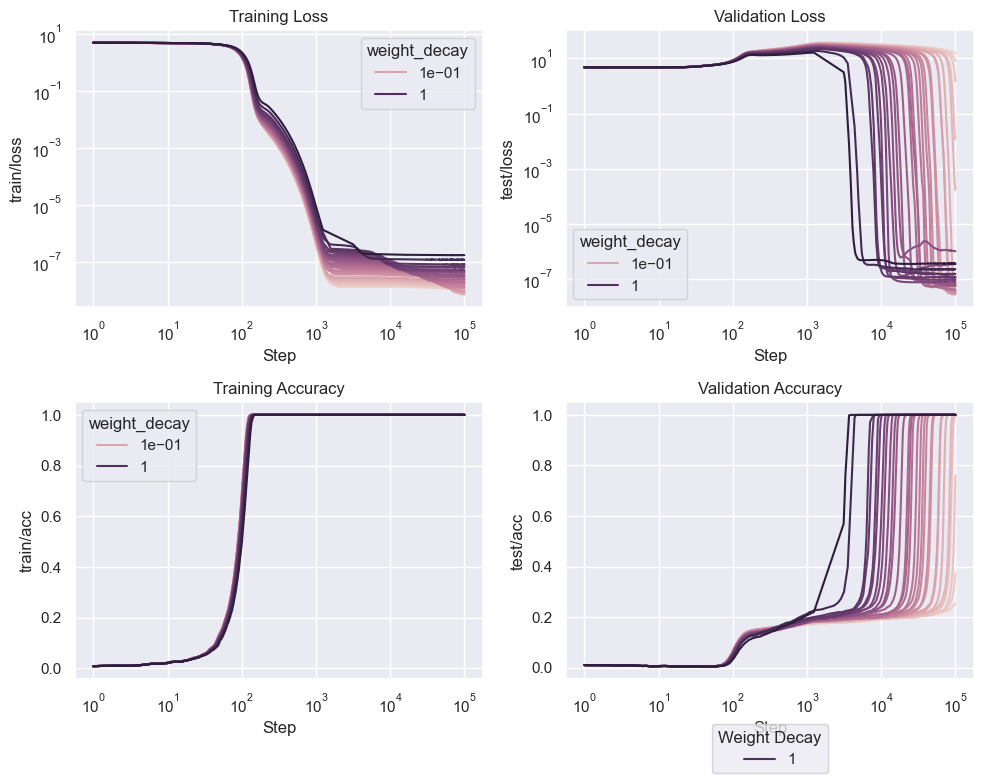

In [93]:
# Plot the learning curves [(_step, "train/loss")], [(_step, "test/loss")], [(_step, "train/acc")], [(_step, "test/acc")]
# for each value of "weight_decay". Use the "hue" argument to color the lines by "weight_decay".

from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

def plot_curves_2x2(df: pd.DataFrame, title: str, unique_col: str, log_color: bool = True):
    # Set up the subplot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Define the columns to plot
    columns = [("_step", "train/loss"), ("_step", "test/loss"), 
            ("_step", "train/acc"), ("_step", "test/acc")]
    subtitles = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]

    n_unique = df[unique_col].nunique()

    # Loop through each column and plot the learning curve
    for i, (column, subtitle) in enumerate(zip(columns, subtitles)):
        row = i // 2
        col = i % 2
        ax = axes[row][col]
        
        if log_color:
            sns.lineplot(data=df, x=column[0], y=column[1], hue=unique_col, hue_norm=LogNorm(), ax=ax)
        else:
            sns.lineplot(data=df, x=column[0], y=column[1], hue=unique_col, ax=ax)

        ax.set_title(subtitle)
        ax.set_xscale('log')
        ax.set_xlabel("Step")
        # ax.set_ylabel(column[1])

        if "loss" in column[1]:
            ax.set_yscale('log')

    # Add a legend to the last subplot (in the form of a heatmap)
    handles, labels = axes[1][1].get_legend_handles_labels()
    axes[1][1].legend(handles=handles[1:], labels=labels[1:], title=title, loc="center", bbox_to_anchor=(0.5, -0.25), ncol=n_unique, title=title)

    # Adjust the layout of the subplots
    fig.tight_layout()

plot_curves_2x2(reg_sweep_history_cleaned, title="Weight Decay", unique_col="weight_decay")

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def plot(df: pd.DataFrame, smooth: Union[bool, float]=False, log_loss=True, cmap="inferno", titles: Optional[dict]=None, unique_col: str = "weight_decay", log_x: bool = True, log_y: bool = True, title: str = ""):
    # Set up the subplot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Define the columns to plot
    columns = ["train/loss", "test/loss", "train/acc", "test/acc"]

    # Create a pivot table with the data
    pivot_table = pd.pivot_table(df, values=columns, index="_step", columns=unique_col)

    # Fill in the missing values using linear interpolation and gaussian smoothing
    pivot_table = pivot_table.reindex(np.arange(df._step.min(), df._step.max()+1))

    # This will be used to fill in the missing values for the first few steps
    pivot_table = pivot_table.interpolate(method="linear").fillna(method="bfill")

    unique_vals = sorted(df[unique_col].unique())

    # Loop through each column and plot the heatmap
    for i, column in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = axes[row][col]

        # Create a meshgrid for the x and y edges
        X, Y = np.meshgrid(unique_vals, pivot_table[column].index)

        # Apply a Gaussian filter

        data = pivot_table[column].values
        
        if smooth:
            data = gaussian_filter(pivot_table[column].values, sigma=float(smooth))

        if "loss" in column and log_loss:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap, norm=LogNorm())
        else:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap)

        subtitle = titles.get(column, column) if titles else column
        ax.set_title(subtitle)
        ax.set_xlabel(title)
        ax.set_ylabel("Steps")
        
        if log_y:
            ax.set_yscale('log')

        if log_x:
            ax.set_xscale('log')

        ax.set_ylim(df._step.max(), df._step.min())
        ax.set_yticks([1, 10, 100, 1000, 10000, df._step.max()])
        ax.set_xlim(unique_vals[0], unique_vals[-1])
        ax.invert_yaxis()
        
        # Add a colorbar to each subplot
        fig.colorbar(mesh, ax=ax)

    # Adjust the layout of the subplots
    fig.tight_layout()

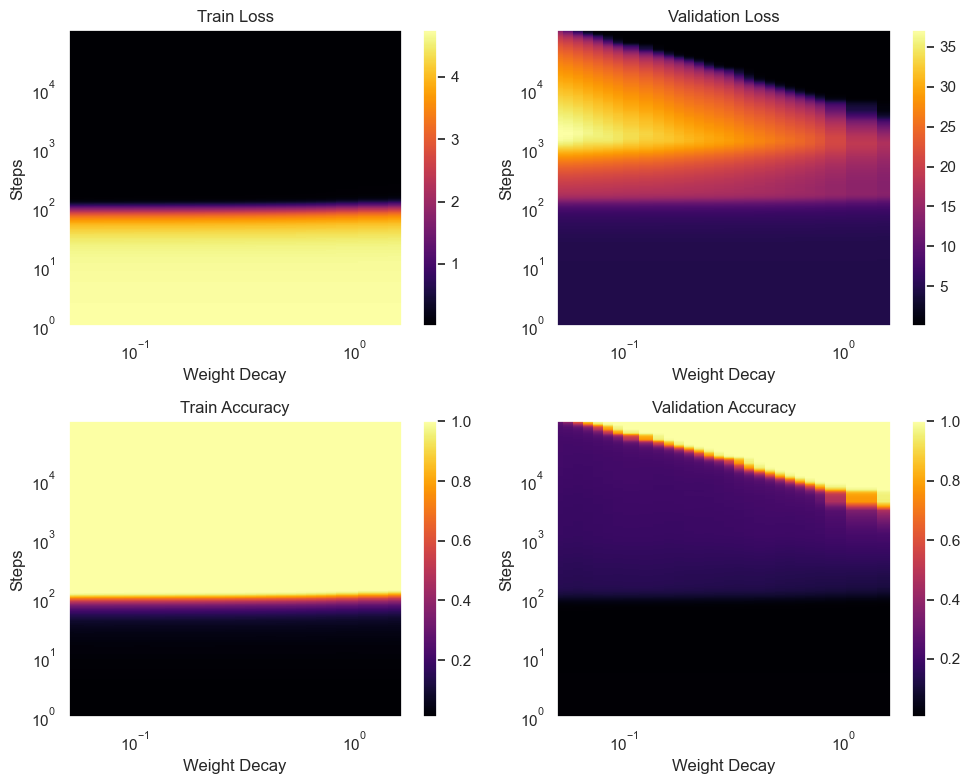

In [106]:
plot(reg_sweep_history_cleaned,   smooth=True, log_loss=False, titles = {
    "train/loss": "Train Loss",
    "test/loss": "Validation Loss",
    "train/acc": "Train Accuracy",
    "test/acc": "Validation Accuracy"
}, title="Weight Decay")

In [98]:
frac_train = get_history("bv34ulfl", unique_col="weight_decay")
frac_train_cleaned = handle_outliers(
    frac_train,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)
frac_train_cleaned

,_step,_runtime,test/loss,test/efficiency,train/loss,test/acc,weight/norm,weight/dist_from_init,weight/cos_sim_with_init,train/acc,...,num_ctx,num_heads,batch_size,frac_train,num_layers,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion
0,1,2.888422,4.770536e+00,1.124242e-01,4.770056e+00,0.007974,42.433351,0.000000,1.000000,0.008876,...,3,4,3830,0.45,1,10,0.3,0,50000,1
1,1,6.348956,4.752047e+00,1.120275e-01,4.732820e+00,0.008266,42.418581,0.484369,0.999935,0.007837,...,3,4,3830,0.10,1,10,0.3,0,50000,1
2,2,3.338614,4.747301e+00,1.119724e-01,4.739880e+00,0.007825,42.397085,0.767263,0.999837,0.007914,...,3,4,3830,0.95,1,10,0.3,0,50000,1
3,3,3.619266,4.748711e+00,1.120398e-01,4.732076e+00,0.006090,42.384141,1.035219,0.999703,0.007690,...,3,4,3830,0.55,1,10,0.3,0,50000,1
4,4,3.520782,4.757738e+00,1.122204e-01,4.706941e+00,0.008810,42.396364,1.548023,0.999334,0.012143,...,3,4,3830,0.20,1,10,0.3,0,50000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,49940,3055.999954,3.543670e+01,7.727034e-01,5.896527e-08,0.010767,45.860672,52.414360,0.297151,1.000000,...,3,4,3830,0.20,1,10,0.3,0,50000,1
189,49950,3723.534842,2.905248e-08,9.990118e-10,2.294682e-08,1.000000,29.081218,48.150881,0.132818,1.000000,...,3,4,3830,0.50,1,10,0.3,0,50000,1
371,49960,3849.052183,2.996593e-08,1.007359e-09,2.602755e-08,1.000000,29.747016,48.064591,0.148649,1.000000,...,3,4,3830,0.95,1,10,0.3,0,50000,1
277,49970,1401.607202,6.046664e+01,2.109929e+00,2.071548e-08,0.004369,28.658144,46.483629,0.189608,1.000000,...,3,4,3830,0.05,1,10,0.3,0,50000,1


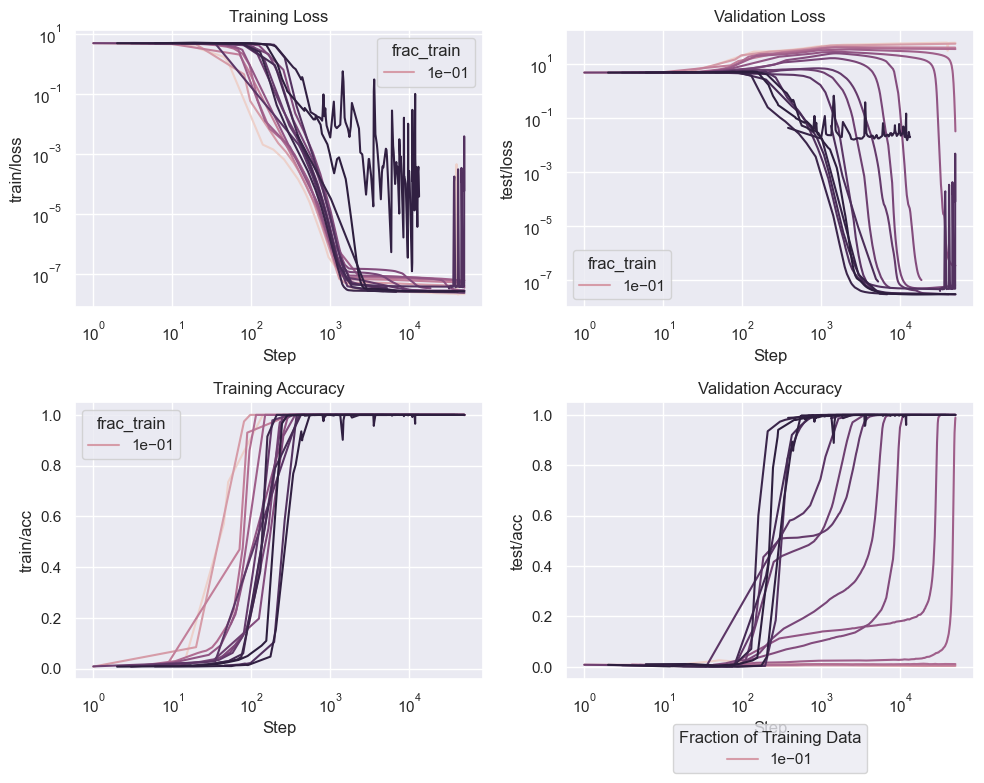

In [109]:
plot_curves_2x2(frac_train_cleaned, title="Fraction of Training Data", unique_col="frac_train")

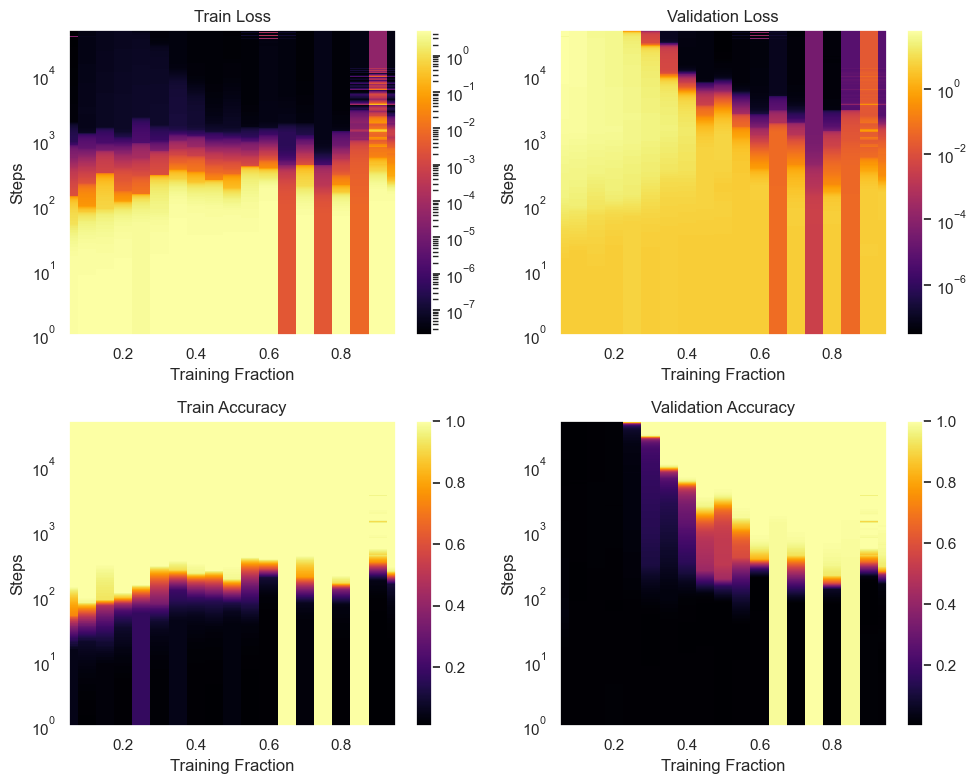

In [120]:
plot(frac_train_cleaned, smooth=0.25, log_loss=True, titles = {
    "train/loss": "Train Loss",
    "test/loss": "Validation Loss",
    "train/acc": "Train Accuracy",
    "test/acc": "Validation Accuracy"
}, unique_col="frac_train", title="Training Fraction", log_x=False)

## Interpolation

In [3]:
# import cifar10    
from typing import List
from torch.utils.data import Subset, Dataset
from torchvision.datasets import MNIST, CIFAR10, VisionDataset
from torchvision import transforms

from grokking.learner import BaseLearner, Reduction

class ExtModule(nn.Module):
    def __init__(self, init_scale: float = 1., init_mode: Literal["uniform", "normal"]="uniform", **kwargs):
        super().__init__(**kwargs)

        self.init_scale = init_scale
        self.init_mode = init_mode

    def init_weights(self):
        for p in self.parameters():
            # if self.init_mode == "uniform":
            #     nn.init.kaiming_uniform_(p.data, a=0, mode='fan_in', nonlinearity='relu')
            # else:
            #     nn.init.kaiming_normal_(p.data, a=0, mode='fan_in', nonlinearity='relu')

            p.data *= self.init_scale

@dataclass
class VisionConfig(Config):
    init_scale: float = 1.
    init_mode: Literal["uniform", "normal"] = "uniform"

    # Dataset
    frac_train: float = 0.2
    frac_label_noise: float = 0.0
     

class VisionLearner(BaseLearner):
    Config = VisionConfig
    Dataset = Union[VisionDataset, Subset[VisionDataset]]


    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        if train and config.frac_train < 1.0:
            indices = torch.randperm(len(dataset))[:int(len(dataset) * config.frac_train)].tolist()
            dataset = Subset(dataset, indices)

        def add_label_noise(dataset: VisionLearner.Dataset, frac_label_noise: float) -> VisionLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )
    

### Can we recreate grokking on MNIST?

In [4]:
# Normalize & transform to tensors
mnist_train = MNIST(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
mnist_test = MNIST(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
class MLP(ExtModule):
    def __init__(
        self, 
        in_size: int,
        num_layers: int,
        num_classes: int,
        width: int,
        **kwargs
    ):
        super().__init__(**kwargs)
 
        self.in_size = in_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.width = width

        layers: List[nn.Module] = [
            nn.Flatten(),
            nn.Linear(in_size, width),
            nn.ReLU()
        ]

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, num_classes))
        self.layers = nn.Sequential(*layers)

        self.init_weights()

    def forward(self, x):
        return self.layers(x)


@dataclass
class MNISTConfig(VisionConfig):
    # Model
    in_size: int = 784
    num_layers: int = 2
    num_classes: int = 10
    width: int = 200
   
class MNISTLearner(VisionLearner):
    Config = MNISTConfig
    Dataset = Union[MNIST, Subset[MNIST]]

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = MLP(
            in_size=config.in_size,
            num_layers=config.num_layers,
            num_classes=config.num_classes,
            width=config.width,
            init_scale=config.init_scale,
            init_mode=config.init_mode,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

    @staticmethod
    def criterion(outputs, targets, reduction: Reduction = "mean"):
        """
        Wrapper around MSE
        """     
        logits = outputs
        one_hot_targets = F.one_hot(targets, num_classes=10).float()
        return F.mse_loss(logits, one_hot_targets, reduction=reduction)


In [218]:
mnist_config = MNISTConfig(
    wandb_project="mnist-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_learner = MNISTLearner.create(
    mnist_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [30]:
try:
    wandb.init(
        project="mnist-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_config),  # Default config
    )
    mnist_learner.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

### Can we induce grokking in CIFAR-10?

In [9]:
# Transform to black & white & crop to 28 x 28 & normalize

cifar_train_bw = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))
cifar_test_bw = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))

# First try with the MNIST model

cifar_config_bw = MNISTConfig(
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

cifar_learner_bw = MNISTLearner.create(
    cifar_config_bw,
    cifar_train_bw,
    cifar_test_bw,
)

Files already downloaded and verified
Files already downloaded and verified
Model has 199210 trainable parameters


In [10]:
try:
    wandb.init(
        project="cifar-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(cifar_config_bw),  # Default config
    )
    cifar_learner_bw.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

test/acc,▂▁▂▂▂▂▂▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇████████████
test/efficiency,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▁▄▆▆▇▇█████████████████████████████████
train/efficiency,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight/cos_sim_with_init,██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
weight/dist_from_init,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
weight/norm,███▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test/acc,0.2119
test/efficiency,0.016


In [219]:
class ResBlock(ExtModule):
    def __init__(self, in_channels, out_channels, kernel_size=3, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.conv3:
            x = self.conv3(x)
        
        out += x
        return F.relu(out)

class ResNet(ExtModule):
    def __init__(
        self, 
        num_blocks: int,
        num_classes: int,
        in_channels: int = 3,
        in_width: int = 32,
        init_scale: float = 1.,
    ):
        super().__init__()

        self.in_width = in_width
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.init_scale = init_scale
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=0, bias=False)
        size = (in_width - 5) // 2 + 1

        self.bn1 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        size = (size - 3) // 2 + 1

        resblocks = [
            ResBlock(32 * (2 ** i), 32 * (2 ** (i + 1)), strides=2, kernel_size=3)
            for i in range(num_blocks)
        ]

        for i, _ in enumerate(resblocks):
            size = (size - 3) // 2 + 1

        self.resblocks = nn.Sequential(*resblocks)

        self.flatten = nn.Flatten()
        num_channels = 32 * (2 ** num_blocks)
        self.fc1 = nn.Linear(num_channels * size, num_classes)

        self.init_weights()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.maxpool(out)
        out = self.resblocks(out)
        out = self.flatten(out)
        out = self.fc1(out)
        return out
    

@dataclass
class CIFARConfig(VisionConfig):
    num_blocks: int = 2
    num_classes: int = 10
    in_channels: int = 3
    in_width: int = 32 


class CIFARLearner(BaseLearner):
    Config = CIFARConfig
    Dataset = Union[CIFAR10, Subset[CIFAR10]]

    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        if train and config.frac_train < 1.0:
            dataset = Subset(
                dataset, 
                list(range(int(len(dataset) * config.frac_train)))
            )

        def add_label_noise(dataset: CIFARLearner.Dataset, frac_label_noise: float) -> CIFARLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = ResNet(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            in_channels=config.in_channels,
            in_width=config.in_width,
            init_scale=config.init_scale,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar_config = CIFARConfig(
    batch_size=128,
    wandb_project="cifar10-grokking",
    frac_train=0.0167,
    init_scale=6,
)

cifar_learner = CIFARLearner.create(
    cifar_config,
    trainset=cifar_train,
    testset=cifar_test,
)    
    

### Can we interpolate just by varying initialization scale and label noise?

## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?